# 1. Preparación de entorno. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from pmdarima import auto_arima
%pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
import ruptures as rpt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

Note: you may need to restart the kernel to use updated packages.


# 2. Carga de datos. 

In [2]:
# Load the lake hydrology data
df_rivers = pd.read_csv("../data/processed/rivers/river_hydrology_data_clean.csv")
df_rivers.head()

,Date,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
0,1998-01-01,1,0.0,0.0,1.82
1,1998-01-02,1,0.0,0.0,1.94
2,1998-01-03,1,0.0,0.0,2.11
3,1998-01-04,1,0.0,0.0,1.84
4,1998-01-05,1,0.0,0.0,1.88


# 3. Definir Features (X) y Variable Target (Y). 

Para definir las variables features y la variable target, se considerarán los datos que nos son útiles para visualizar el nivel de agua según la fecha de cada cuerpo de agua, en este caso __"Value"__ es la variable target, mientras que el resto de las variables se considerarán variables feature.

# 4. Dividir data en train y test. 

In [3]:
df_rivers["Date"] = pd.to_datetime(df_rivers["Date"])

In [4]:
df_rivers.set_index("Date", inplace=True)

In [5]:
df_rivers.sort_index(inplace=True)

In [6]:
df_monthly = df_rivers.resample('M').mean() 

/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_32863/1901548509.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_rivers.resample('M').mean()


In [7]:
df_monthly.head()

,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
Date,,,,
1998-01-31,7.5,0.0,0.0,1.862903
1998-02-28,7.5,0.0,0.0,1.691786
1998-03-31,7.5,0.0,0.0,1.682258
1998-04-30,7.5,0.0,0.0,2.198000
1998-05-31,7.5,0.0,0.0,1.718710


In [8]:
df = df_monthly

In [9]:
split_date = '2019-01-01' # Ejemplo de tu fecha de división
train_df = df[:split_date]
test_df = df.loc[(df.index > split_date)]

In [10]:
# Dividir los datos en entrenamiento y prueba
n_obs = 50 # Número de observaciones para predecir
train_df = train_df[:-n_obs]
test_df = test_df[-n_obs:]

print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

Tamaño del conjunto de entrenamiento: 202
Tamaño del conjunto de prueba: 18


In [ ]:
#train_df.describe()

,Rainfall_Location,Rainfall_Value,Temperature_Value,Hydrometry_Value
count,202.0,202.000000,202.000000,202.000000
mean,7.5,1.244577,13.913135,1.460371
std,0.0,1.439341,8.573502,0.506562
min,7.5,0.000000,0.000000,0.000000
25%,7.5,0.000000,7.391662,1.128226
50%,7.5,0.794240,13.790215,1.345269
75%,7.5,2.115173,21.461250,1.781129
max,7.5,7.730476,29.458065,2.883214


In [12]:
train_df.drop(columns=['Rainfall_Location'], inplace=True)

In [13]:
# # Suponiendo que df ya está cargado y preprocesado
# # y que var_columns_all está definido
# var_columns_all = ['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']
# df_plot = train_df[var_columns_all]

# # 1. Definir los conjuntos de entrenamiento y prueba
# # En este caso, el conjunto de 'prueba' será la predicción futura.
# # Por lo tanto, usaremos todos los datos disponibles para entrenar el modelo.
# train_df = df_plot.copy()
# # Número de pasos que quieres predecir en el futuro
# n_forecast = 12 

# # 2. Entrenar el modelo VAR
# model = VAR(train_df)
# # Ajusta el modelo. `ic='aic'` encuentra el mejor número de lags
# results = model.fit(maxlags=5, ic='aic')
# lag_order = results.k_ar

# # 3. Realizar el pronóstico (forecast)
# # Usar los últimos datos disponibles para el inicio de la predicción
# input_data = train_df.values[-lag_order:]
# forecast = results.forecast(y=input_data, steps=n_forecast)

# # 4. Crear un DataFrame para la predicción futura
# # Generar un rango de fechas futuras para el índice
# last_date = train_df.index[-1]
# future_dates = pd.date_range(start=last_date, periods=n_forecast + 1, freq=train_df.index.freq)[1:]

# forecast_df = pd.DataFrame(forecast, index=future_dates, columns=var_columns_all)

# # 5. Visualizar los resultados
# for column in var_columns_all:
#     plt.figure(figsize=(14, 8))
    
#     # Graficar los datos históricos de entrenamiento
#     sns.lineplot(data=train_df[column], label='Datos Históricos (Entrenamiento)', color='blue')
    
#     # Graficar la predicción futura
#     sns.lineplot(data=forecast_df[column], label='Pronóstico Futuro', color='red', linestyle='--')
    
#     # Opcional: Sombrear el área de predicción para distinguirla de los datos históricos
#     plt.axvline(x=forecast_df.index[0], color='gray', linestyle=':', label='Inicio del Pronóstico')
    
#     plt.title(f'Pronóstico del Modelo VAR para {column}', fontsize=16)
#     plt.xlabel('Fecha')
#     plt.ylabel('Valor')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [14]:
# # Crear y ajustar el modelo VAR
# model = VAR(train_df)

# # Encontrar el orden óptimo del modelo (p)
# # statsmodels puede sugerir el orden basándose en criterios como AIC, BIC, etc.
# # Aquí usamos un orden fijo por simplicidad, pero se recomienda optimizarlo.
# results = model.fit(maxlags=2, ic='aic') # Probar hasta 2 retardos y usar AIC para la selección

# print("Resumen del modelo ajustado:")
# print(results.summary())

# # Realizar la predicción
# lag_order = results.k_ar
# print(f"Orden de retardo (lags) del modelo: {lag_order}")

# # Obtener los datos más recientes para la predicción
# input_data = train_df.values[-lag_order:]

# # Predecir el siguiente punto de datos
# forecast = results.forecast(y=input_data, steps=n_obs)

# # Lista de columnas que se usaron para el entrenamiento
# var_columns = ['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']

# # # Convertir la predicción a DataFrame
# # # Usamos la lista de columnas 'var_columns' en lugar de df.columns
# forecast = results.forecast(y=input_data, steps=len(test_df))

# print("\nPredicciones del modelo:")
# print(forecast)
# print("\nValores reales:")
# print(test_df)
# # Convertir la predicción a DataFrame para facilitar la visualización
# #forecast_df = pd.DataFrame(forecast, index=test_df.index, columns=df.columns)

# # print("\nPredicciones del modelo:")
# # print(forecast_df)
# # print("\nValores reales:")
# # print(test_df)

In [ ]:
#var_columns_all = ['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']

# Seleccionar solo las columnas relevantes del DataFrame original
#df_plot = df[['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']]


In [ ]:
#df_plot.head()

,Rainfall_Value,Temperature_Value,Hydrometry_Value
Date,,,
1998-01-31,0.0,0.0,1.862903
1998-02-28,0.0,0.0,1.691786
1998-03-31,0.0,0.0,1.682258
1998-04-30,0.0,0.0,2.198000
1998-05-31,0.0,0.0,1.718710


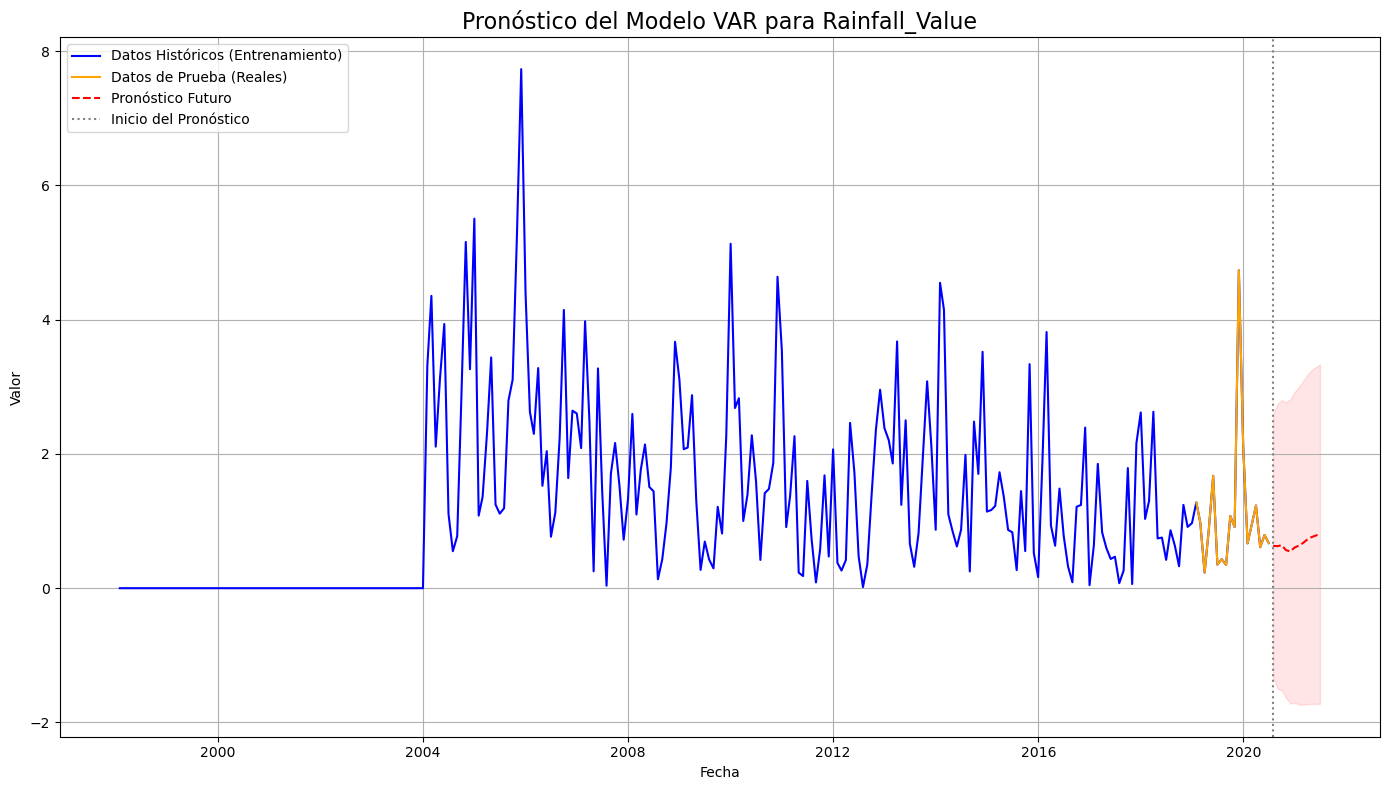

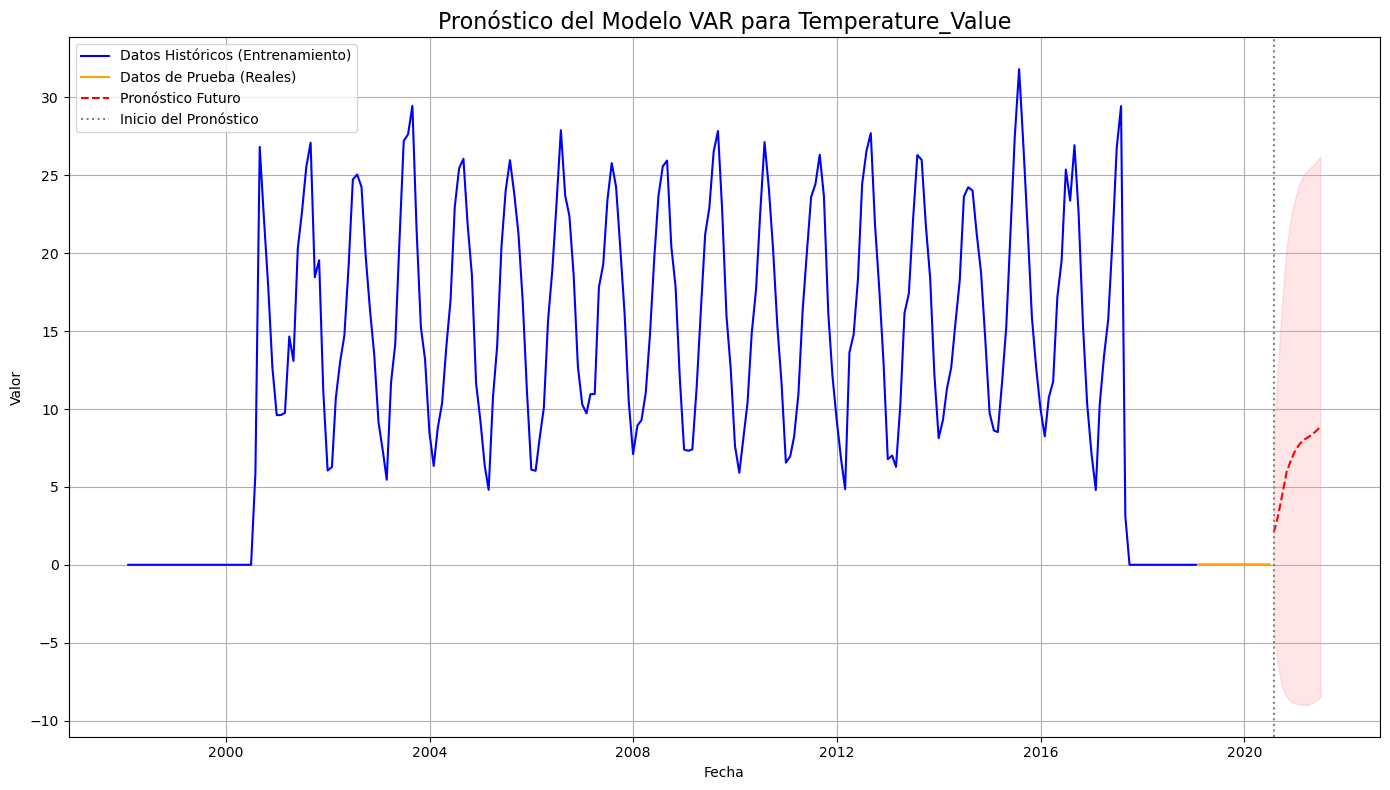

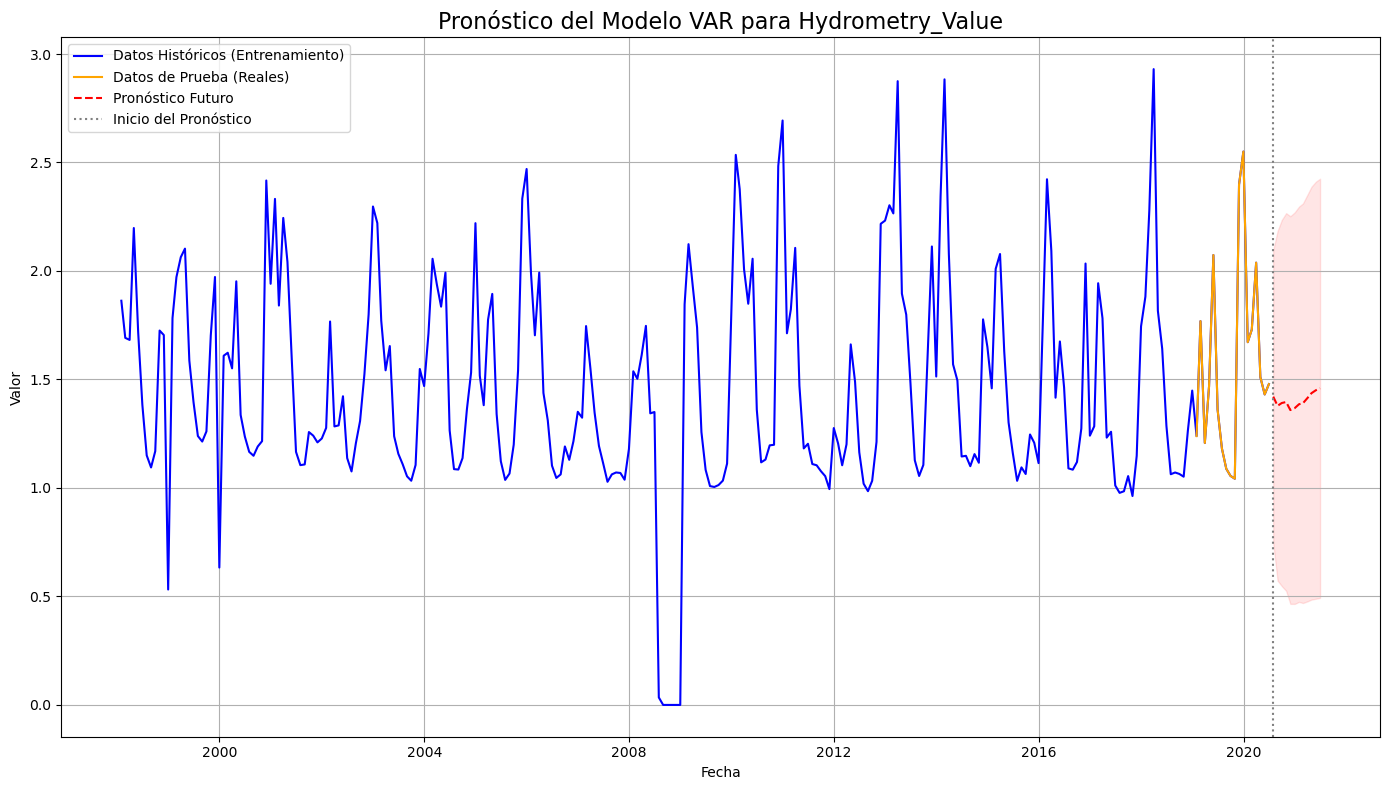

In [19]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from statsmodels.tsa.api import VAR
# import numpy as np

# Suponiendo que df ya está cargado y preprocesado
# y que var_columns_all está definido
var_columns_all = ['Rainfall_Value', 'Temperature_Value', 'Hydrometry_Value']
df_plot = df[var_columns_all]

# 1. Definir el conjunto de entrenamiento (usando todos los datos disponibles)
train_df = df_plot.copy()
# Número de pasos que quieres predecir en el futuro
n_forecast = 12 

# 2. Entrenar el modelo VAR
model = VAR(train_df)
results = model.fit(maxlags=5, ic='aic')
lag_order = results.k_ar

# 3. Realizar el pronóstico (forecast) y calcular el intervalo de confianza
input_data = train_df.values[-lag_order:]
forecast_result = results.forecast_interval(y=input_data, steps=n_forecast, alpha=0.05)

# 4. Desempaquetar los resultados del pronóstico
# forecast_result devuelve una tupla con (pronóstico, límite inferior, límite superior)
forecast_values = forecast_result[0]
lower_bound = forecast_result[1]
upper_bound = forecast_result[2]

# 5. Crear DataFrames para la predicción futura y sus límites
last_date = train_df.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_forecast + 1, freq=train_df.index.freq)[1:]

forecast_df = pd.DataFrame(forecast_values, index=future_dates, columns=var_columns_all)
lower_df = pd.DataFrame(lower_bound, index=future_dates, columns=var_columns_all)
upper_df = pd.DataFrame(upper_bound, index=future_dates, columns=var_columns_all)

# 6. Visualizar los resultados con el área sombreada
for column in var_columns_all:
    plt.figure(figsize=(14, 8))
    
    # Graficar los datos históricos de entrenamiento
    sns.lineplot(data=train_df[column], label='Datos Históricos (Entrenamiento)', color='blue')

    # Graficar los datos reales del conjunto de prueba
    sns.lineplot(data=test_df[column], label='Datos de Prueba (Reales)', color='orange')
    
    # Graficar el pronóstico futuro
    sns.lineplot(data=forecast_df[column], label='Pronóstico Futuro', color='red', linestyle='--')
    
    # Sombrear el área del intervalo de confianza
    plt.fill_between(forecast_df.index, lower_df[column], upper_df[column], color='red', alpha=0.1)

    plt.axvline(x=forecast_df.index[0], color='gray', linestyle=':', label='Inicio del Pronóstico')
    
    plt.title(f'Pronóstico del Modelo VAR para {column}', fontsize=16)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()